## Measuring the latent representations: activations of the message functions

In [11]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from model import *
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

In [12]:
#load the data
data = load_data('../simulations/datasets/r1_n=3_dim=2_nt=1000_dt=0.005')
X, y = data

#make train, test, val sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=False)

train the model

In [ ]:
cutoff = 50000
val_cutoff = int(cutoff*0.25)

#train the model on a small amount of data
model = train((X_train[:cutoff], y_train[:cutoff]), (X_val[:cutoff], y_val[:cutoff]), 30, patience= 5)

Epoch: 1/30: 100%|██████████| 1563/1563 [00:09<00:00, 166.76it/s]


training loss: 0.7438, val loss: 0.8829
new best validation loss: 0.8829


Epoch: 2/30: 100%|██████████| 1563/1563 [00:09<00:00, 167.50it/s]


training loss: 0.4467, val loss: 0.7530
new best validation loss: 0.7530


Epoch: 3/30: 100%|██████████| 1563/1563 [00:09<00:00, 165.86it/s]


training loss: 0.3749, val loss: 0.6245
new best validation loss: 0.6245


Epoch: 4/30: 100%|██████████| 1563/1563 [00:11<00:00, 137.78it/s]


training loss: 0.3383, val loss: 0.5802
new best validation loss: 0.5802


Epoch: 5/30: 100%|██████████| 1563/1563 [00:10<00:00, 143.38it/s]


training loss: 0.3207, val loss: 0.5410
new best validation loss: 0.5410


Epoch: 6/30: 100%|██████████| 1563/1563 [00:11<00:00, 139.48it/s]


training loss: 0.2904, val loss: 0.5697
EarlyStopping counter: 1 out of 5


Epoch: 7/30: 100%|██████████| 1563/1563 [00:10<00:00, 152.19it/s]


training loss: 0.2821, val loss: 0.5680
EarlyStopping counter: 2 out of 5


Epoch: 8/30: 100%|██████████| 1563/1563 [00:11<00:00, 139.06it/s]


training loss: 0.2754, val loss: 0.5265
new best validation loss: 0.5265


Epoch: 9/30: 100%|██████████| 1563/1563 [00:11<00:00, 139.87it/s]


training loss: 0.2646, val loss: 0.5283
EarlyStopping counter: 1 out of 5


Epoch: 10/30: 100%|██████████| 1563/1563 [00:10<00:00, 142.92it/s]


training loss: 0.2742, val loss: 0.4829
new best validation loss: 0.4829


Epoch: 11/30: 100%|██████████| 1563/1563 [00:11<00:00, 137.40it/s]


training loss: 0.2589, val loss: 0.4995
EarlyStopping counter: 1 out of 5


Epoch: 12/30: 100%|██████████| 1563/1563 [00:11<00:00, 132.52it/s]


training loss: 0.2567, val loss: 0.5243
EarlyStopping counter: 2 out of 5


Epoch: 13/30: 100%|██████████| 1563/1563 [00:13<00:00, 118.22it/s]


training loss: 0.2539, val loss: 0.5093
EarlyStopping counter: 3 out of 5


Epoch: 14/30: 100%|██████████| 1563/1563 [00:11<00:00, 133.22it/s]


training loss: 0.2569, val loss: 0.5445
EarlyStopping counter: 4 out of 5


Epoch: 15/30: 100%|██████████| 1563/1563 [00:11<00:00, 131.54it/s]


training loss: 0.2512, val loss: 0.5027
EarlyStopping counter: 5 out of 5
Early stopping triggered after 15 epochs
Loaded best model with validation loss: 0.4829


In [179]:
save_model(model, "testing_models/model.pt")

Model saved successfully


In [180]:
test((X_test[:10000], y_test[:10000]), model)

Avg loss:  0.5383523471248798


0.5383523471248798

In [197]:
model = load_model("testing_models/model1.pt")

Model loaded successfully


In [198]:
test((X_test[:10000], y_test[:10000]), model)

Avg loss:  0.5741797078388948


0.5741797078388948

get the message features along with other information from the trained model and test data

In [199]:
def get_message_features(model, input_data, batch_size=32):
    """
    Make pd.Dataframe of messages and particle information
    
    Args:
        model (NBodyGNN): Trained model
        input_data (torch.Tensor): Input data with shape [no_timesteps, no_nodes, node_features]
        batch_size (int): Size of batches to process
        
    Returns:
        pd.DataFrame: DataFrame containing node features and message features
        numpy.ndarray: just the message features
    """

    model.eval()  
    edge_index = get_edge_index(input_data.shape[1])
    
    # Create dataloader
    dataset = TensorDataset(input_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_message_info = []
    
    with torch.no_grad():
        for (nodes,) in dataloader:
            x_i = nodes[:, edge_index[0]]  # Source nodes
            x_j = nodes[:, edge_index[1]]  # Target nodes
            
            x = torch.cat((x_i, x_j), dim=-1)
            messages = model.edge_model(x) #put thru edge model
            #messages shape is [batch_size, num_edges, 100]
            
            #combine node features with messages along final axis
            message_info = torch.cat((x_i, x_j, messages), dim=-1)
            
            #reshape batch_messages to be 2D for pandas: [batch_size * num_edges, features]
            #batch info and edge info doesnt matter. only related feature info and latent messages
            message_info = message_info.reshape(-1, message_info.shape[-1])
            all_message_info.append(message_info)
    
    # Combine all batches
    message_info = torch.cat(all_message_info, dim=0)
    
    # Convert to numpy for DataFrame creation
    message_info = message_info.numpy()
    
    # Create column names
    node_info = ['x', 'y', 'delta_x', 'delta_y', 'q', 'm'] #for 2d
    source_cols = [f'{f}1' for f in node_info]
    target_cols = [f'{f}2' for f in node_info]
    message_cols = [f'e{i}' for i in range(messages.shape[-1])]
    columns = source_cols + target_cols + message_cols
    
    # Create DataFrame
    message_info = pd.DataFrame(message_info, columns=columns)
    
    # distances between particles
    message_info['x_dist'] = message_info.x1 - message_info.x2
    message_info['y_dist'] = message_info.y1 - message_info.y2
    message_info['r'] = np.sqrt(message_info.x_dist**2 + message_info.y_dist**2)
    
    # Calculate relative velocities
    message_info['dvx'] = message_info.delta_x1 - message_info.delta_x2
    message_info['dvy'] = message_info.delta_y1 - message_info.delta_y2
    message_info['v_rel'] = np.sqrt(message_info.dvx**2 + message_info.dvy**2)

    message_cols = [col for col in message_info.columns if col.startswith('e')]
    message_features = message_info[message_cols].values #shape is [batch_size * num edges, 100]
    
    return message_info, message_features

standard message model (100 outputs). plot the message 

In [200]:
def get_important_features(message_features):
    """get most important (top 2) features (standard) by measuring variance over all data

    Args:
        message_features (numpy.ndarray): just the message features. of shape [datapoints, 100]

    Returns:
        numpy.ndarray: most important two messages. of shape [datapoints, 2]
    """
    std = message_features.std(axis = 0)
    important_elements = np.argsort(std)[-2:]
    return message_features[:, important_elements]

In [201]:
def get_force(message_info, sim = 'r1'):
    """
    get forces for the different simulations
    """
    x_dist = message_info['x_dist']
    y_dist = message_info['y_dist']
    r = message_info['r']
    m1m2 = message_info['m1'] * message_info['m2']
    eps = 1e-6
    if sim == 'r1':
        f = - m1m2 / (r*r + eps)
        f_x = f * x_dist / (r+eps)
        f_y = f * y_dist / (r+eps)
    return np.array(f), np.array(f_x), np.array(f_y)


fit linear combination of forces to messsage components-linear regression tings

In [229]:
from sklearn.linear_model import LinearRegression


#currently removing percentage outliers for fitting
#is this ok? who knows - probably change this when can train the model more later
def remove_outliers(fx, fy, best_messages, perc):
    lower_bound_x = np.percentile(fx, perc)
    upper_bound_x = np.percentile(fx, 100 - perc)
    
    # Calculate percentile bounds for fy
    lower_bound_y = np.percentile(fy, perc)
    upper_bound_y = np.percentile(fy, 100 - perc)
    
    # Create masks for each array
    mask_x = (fx >= lower_bound_x) & (fx <= upper_bound_x)
    mask_y = (fy >= lower_bound_y) & (fy <= upper_bound_y)
    
    # Combined mask - keep only points where both fx and fy are not outliers
    combined_mask = mask_x & mask_y

    fx_clean = fx[combined_mask]
    fy_clean = fy[combined_mask]
    best_messages_clean = best_messages[combined_mask, :]


    return fx_clean, fy_clean, best_messages_clean


def fit_coefficients(message_elem, fx, fy):
    """
    Fit coefficients for linear combination of forces
    Returns a, b coefficients for a*fx + b*fy
    """
    X = np.column_stack([fx, fy])
    lin_reg = LinearRegression()
    lin_reg.fit(X, message_elem)
    return lin_reg.coef_[0], lin_reg.coef_[1]

cut away the outliers when plotting -is this ok?

In [347]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def r2_plots(model, input_data, perc = 1):

    message_info, message_features = get_message_features(model, input_data)#get message info
    best_messages = get_important_features(message_features)#get most important messages (variance)
    _, fx, fy = get_force(message_info) #get forces
    if perc != 0: #cut away outliers
        fx, fy, best_messages = remove_outliers(fx, fy, best_messages, perc=perc)
    
    #linear fit forces to messages
    a,b = fit_coefficients(best_messages[:,0], fx, fy)
    c,d = fit_coefficients(best_messages[:,1], fx, fy)
    lin_combo1 = a*fx +b*fy
    lin_combo2 = c*fx +d*fy

    #plot
    fig, ax = plt.subplots(1,2, figsize = (10,5))

    message1_r2 = r2_score (best_messages[:,0], lin_combo1)
    message2_r2 = r2_score (best_messages[:,1], lin_combo2)

    lin_x1 = np.linspace(min(lin_combo1), max(lin_combo1), 100)
    lin_y1 = lin_x1

    lin_x2 = np.linspace(min(lin_combo2), max(lin_combo2), 100)
    lin_y2 = lin_x2

    ax[0].plot(lin_combo1, best_messages[:,0], 'o', markersize = '0.5', label = f"{a:.2g} Fx + {b:.2g} Fy")
    ax[0].plot(lin_x1, lin_y1, color = 'black')
    ax[0].grid()
    ax[0].set_xlabel(f"Linear combination of forces")
    ax[0].set_ylabel(f"Message element 1")
    ax[0].legend()
    ax[0].set_title(f"R2 Score {message1_r2: .5g}")

    ax[1].plot(lin_combo2, best_messages[:,1], 'o', markersize = '0.5', label = f"{c:.2g} Fx + {d:.2g} Fy")
    ax[1].plot(lin_x2, lin_y2, color = 'black')
    ax[1].grid()
    ax[1].set_xlabel(f"Linear combination of forces")
    ax[1].set_ylabel(f"Message element 2")
    ax[1].legend()
    ax[1].set_title(f"R2 Score {message2_r2: .5g}")

    return message1_r2, message2_r2

In [348]:
N = 10000
np.random.seed(290402)
rand_idx = np.random.choice(len(X_test), size = N, replace = False) #use random N points on the test data
X_test_rand = X_test[rand_idx]
message_info, message_features = get_message_features(model, X_test_rand)

(0.12809908390045166, 0.38732361793518066)

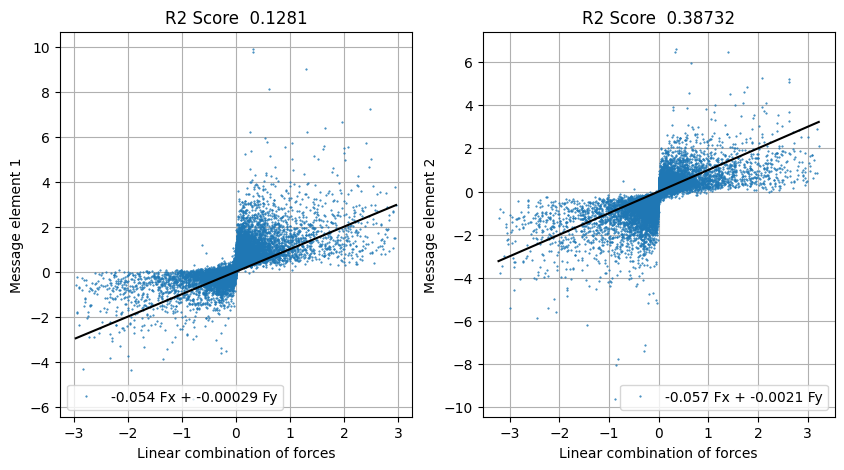

In [349]:
r2_plots(model, X_test_rand)

In [323]:
cutoff = 10000
cutoff_val = int(cutoff*0.25)
model_l1 = train_L1((X_train[:cutoff], y_train[:cutoff]), (X_val[:cutoff], y_val[:cutoff]), 25)

Epoch: 1/30: 100%|██████████| 625/625 [00:06<00:00, 101.48it/s]


training loss: 0.8966, val loss: 1.3358
new best validation loss: 1.3358


Epoch: 2/30: 100%|██████████| 625/625 [00:06<00:00, 90.86it/s]


training loss: 0.5493, val loss: 0.9954
new best validation loss: 0.9954


Epoch: 3/30: 100%|██████████| 625/625 [00:06<00:00, 94.25it/s] 


training loss: 0.4220, val loss: 0.8390
new best validation loss: 0.8390


Epoch: 4/30: 100%|██████████| 625/625 [00:06<00:00, 89.71it/s]


training loss: 0.3900, val loss: 0.8265
new best validation loss: 0.8265


Epoch: 5/30: 100%|██████████| 625/625 [00:05<00:00, 109.04it/s]


training loss: 0.3158, val loss: 0.7182
new best validation loss: 0.7182


Epoch: 6/30: 100%|██████████| 625/625 [00:06<00:00, 91.33it/s] 


training loss: 0.3118, val loss: 0.6732
new best validation loss: 0.6732


Epoch: 7/30: 100%|██████████| 625/625 [00:06<00:00, 94.66it/s] 


training loss: 0.2911, val loss: 0.7711
EarlyStopping counter: 1 out of 10


Epoch: 8/30: 100%|██████████| 625/625 [00:06<00:00, 93.89it/s] 


training loss: 0.2605, val loss: 0.6698
new best validation loss: 0.6698


Epoch: 9/30: 100%|██████████| 625/625 [00:05<00:00, 106.46it/s]


training loss: 0.2661, val loss: 0.6648
new best validation loss: 0.6648


Epoch: 10/30: 100%|██████████| 625/625 [00:07<00:00, 87.26it/s]


training loss: 0.2622, val loss: 0.6264
new best validation loss: 0.6264


Epoch: 11/30: 100%|██████████| 625/625 [00:07<00:00, 85.65it/s]


training loss: 0.2527, val loss: 0.5645
new best validation loss: 0.5645


Epoch: 12/30: 100%|██████████| 625/625 [00:07<00:00, 85.73it/s] 


training loss: 0.2457, val loss: 0.5718
EarlyStopping counter: 1 out of 10


Epoch: 13/30: 100%|██████████| 625/625 [00:06<00:00, 93.29it/s] 


training loss: 0.2328, val loss: 0.7775
EarlyStopping counter: 2 out of 10


Epoch: 14/30: 100%|██████████| 625/625 [00:06<00:00, 97.72it/s] 


training loss: 0.2344, val loss: 0.5727
EarlyStopping counter: 3 out of 10


Epoch: 15/30: 100%|██████████| 625/625 [00:06<00:00, 95.33it/s] 


training loss: 0.2271, val loss: 0.5652
EarlyStopping counter: 4 out of 10


Epoch: 16/30: 100%|██████████| 625/625 [00:06<00:00, 99.32it/s] 


training loss: 0.2288, val loss: 0.5867
EarlyStopping counter: 5 out of 10


Epoch: 17/30: 100%|██████████| 625/625 [00:08<00:00, 76.43it/s] 


training loss: 0.2261, val loss: 0.6596
EarlyStopping counter: 6 out of 10


Epoch: 18/30: 100%|██████████| 625/625 [00:06<00:00, 90.42it/s] 


training loss: 0.2268, val loss: 0.5341
new best validation loss: 0.5341


Epoch: 19/30: 100%|██████████| 625/625 [00:06<00:00, 96.38it/s] 


training loss: 0.2159, val loss: 0.5602
EarlyStopping counter: 1 out of 10


Epoch: 20/30: 100%|██████████| 625/625 [00:05<00:00, 107.64it/s]


training loss: 0.2206, val loss: 0.5586
EarlyStopping counter: 2 out of 10


Epoch: 21/30: 100%|██████████| 625/625 [00:06<00:00, 92.43it/s] 


training loss: 0.2159, val loss: 0.5722
EarlyStopping counter: 3 out of 10


Epoch: 22/30: 100%|██████████| 625/625 [00:06<00:00, 99.07it/s] 


training loss: 0.2199, val loss: 0.7172
EarlyStopping counter: 4 out of 10


Epoch: 23/30: 100%|██████████| 625/625 [00:06<00:00, 98.52it/s] 


training loss: 0.2135, val loss: 0.6086
EarlyStopping counter: 5 out of 10


Epoch: 24/30: 100%|██████████| 625/625 [00:05<00:00, 115.37it/s]


training loss: 0.2074, val loss: 0.6685
EarlyStopping counter: 6 out of 10


Epoch: 25/30: 100%|██████████| 625/625 [00:07<00:00, 85.87it/s] 


training loss: 0.2073, val loss: 0.5629
EarlyStopping counter: 7 out of 10


Epoch: 26/30: 100%|██████████| 625/625 [00:06<00:00, 95.69it/s] 


training loss: 0.1935, val loss: 0.5451
EarlyStopping counter: 8 out of 10


Epoch: 27/30: 100%|██████████| 625/625 [00:06<00:00, 95.25it/s] 


training loss: 0.2087, val loss: 0.5481
EarlyStopping counter: 9 out of 10


Epoch: 28/30: 100%|██████████| 625/625 [00:05<00:00, 117.71it/s]


training loss: 0.2066, val loss: 0.5843
EarlyStopping counter: 10 out of 10
Early stopping triggered after 28 epochs
Loaded best model with validation loss: 0.5341


(0.42072445154190063, 0.4356713891029358)

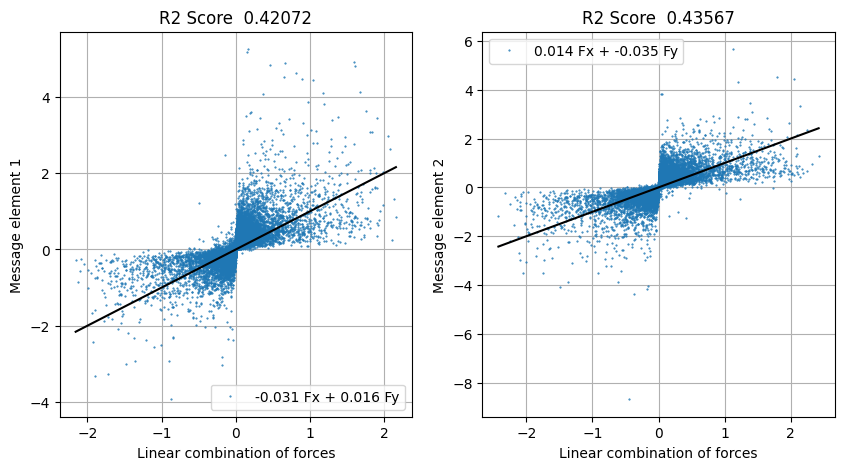

In [350]:
r2_plots(model_l1, X_test_rand)